### Imports

In [1]:
from tqdm import tqdm
import random
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_mtsim
sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/")
from gym_mtsim_forked.gym_mtsim.data import FOREX_DATA_PATH_TRAIN, FOREX_DATA_PATH_TEST, FOREX_DATA_PATH
from gym_mtsim import OrderType, Timeframe, MtEnv, MtSimulator

from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback

import torch

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment forex-hedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment forex-unhedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment stocks-hedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment stocks-unhedge-v0 alr

# Parameters

In [2]:
import pickle
# unpack the pickle file and load the data that is in symbols_forex.pkl
with open('C:/Users/WilliamFetzner/Documents/Trading/gym_mtsim_forked/gym_mtsim/data/symbols_forex.pkl', 'rb') as f:
    symbols = pickle.load(f)
# convert symbols to a pd.dataframe
symbols[1]['EURUSD']
split = int(len(symbols[1]['EURUSD']) * 0.95)
testing_length = len(symbols[1]['EURUSD'].iloc[split:, :].index)
testing_length

5022

In [3]:
training_length = testing_length/.2
validation_length = testing_length/2
final_test = testing_length/2

In [4]:
training_index_slice = symbols[1]['EURUSD'].iloc[-int(training_length):-int(testing_length), :].index
validation_index_slice = symbols[1]['EURUSD'].iloc[-int(testing_length):-int(validation_length), :].index
testing_index_slice = symbols[1]['EURUSD'].iloc[-int(final_test):, :].index

In [5]:
window_size_param = 100

### Create Env

In [6]:
sim_train = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_train = MtEnv(
    original_simulator=sim_train,
    trading_symbols=['EURUSD'],
    window_size = window_size_param,
    time_points=list(training_index_slice),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [7]:
sim_validation = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_validation = MtEnv(
    original_simulator=sim_validation,
    trading_symbols=['EURUSD'],
    window_size = window_size_param,
    time_points=list(validation_index_slice),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [8]:
sim_testing = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_testing = MtEnv(
    original_simulator=sim_testing,
    trading_symbols=['EURUSD'],
    window_size = window_size_param,
    time_points=list(testing_index_slice),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

### Define Functions

In [9]:
def print_stats(reward_over_episodes):
    """  Print Reward  """

    avg_rewards = np.mean(reward_over_episodes)
    min_rewards = np.min(reward_over_episodes)
    max_rewards = np.max(reward_over_episodes)

    print (f'Min. Reward          : {min_rewards:>10.3f}')
    print (f'Avg. Reward          : {avg_rewards:>10.3f}')
    print (f'Max. Reward          : {max_rewards:>10.3f}')

    return min_rewards, avg_rewards, max_rewards


# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


In [10]:
hyperparameters = {
    # it'll be one of these once the other notebook is finished
    'lr': [1e-3, 1e-4, 1e-5], # Learning rate 
    'gamma': [0.9, 0.95, 0.99], # Discount factor
    'ent_coef': [0.01, 0.05, 0.1] # Entropy coefficient
}

In [11]:
# TRAINING + TEST
def train_val_model(model, model_policy, env_tr, env_val, seed, train_len, val_length, testing_len, total_learning_timesteps=10_000):
    """ if model=None then execute 'Random actions' """

    # reproduce training and test
    print('-' * 80)
    obs_tr = env_tr.reset(seed=seed)
    obs_val = env_val.reset(seed=seed)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    model_dict = {}

    vec_env = None
    model = PPO(model_policy, env_tr, verbose=0)

    env_tr.time_points = list(training_index_slice)
    obs_tr, info_tr = env_tr.reset(seed=seed)
    # custom callback for 'progress_bar'
    model.learn(total_timesteps=total_learning_timesteps) #, callback=ProgressBarCallback(100)

    reward_over_validations = []
    balance_over_validations = []

    tbar = tqdm(range(0, 10))

    for episode in tbar:
        testing_len -= 50
        # validation_length += episode
        # Update the training and testing environments
        env_tr.time_points = list(symbols[1]['EURUSD'].iloc[-int(train_len):-int(testing_len), :].index)
        env_val.time_points = list(symbols[1]['EURUSD'].iloc[-int(testing_len):-int(val_length), :].index)
        # env_tr.original_simulator = gym_mtsim.MtSimulator(
        #     unit='USD',
        #     balance=200000.,
        #     leverage=100.,
        #     stop_out_level=0.2,
        #     hedge=True,
        #     symbols_filename=FOREX_DATA_PATH
        # )
        # env_val.original_simulator = gym_mtsim.MtSimulator(
        #     unit='USD',
        #     balance=200000.,
        #     leverage=100.,
        #     stop_out_level=0.2,
        #     hedge=True,
        #     symbols_filename=FOREX_DATA_PATH
        # )
        obs_tr, info_tr = env_tr.reset(seed=seed)
        obs_val, info_validation = env_val.reset(seed=seed)

        model.learn(total_timesteps=total_learning_timesteps) #, callback=ProgressBarCallback(100)

        total_reward = 0
        done_val = False

        while not done_val:
            action, _states = model.predict(obs_val)
            obs_val, reward_val, terminated_val, truncated_val, info_validation = env_val.step(action)
            done_val = terminated_val or truncated_val

            total_reward += reward_val
            if done_val:
                break

        model_dict[f'model_{episode}'] = model
        model.save(f'models_4_17_24/model_{episode}.pkl')

        reward_over_validations.append(total_reward)    
        balance_over_validations.append(info_validation['balance'])  


        if episode % 2 == 0:
            avg_reward = np.mean(reward_over_validations)
            tbar.set_description(f'Episode: {episode}, Avg. Reward: {avg_reward:.3f} Avg. Balance: {np.mean(balance_over_validations):.3f}')
            tbar.update()

    tbar.close()
    avg_reward = np.mean(reward_over_validations)

    return reward_over_validations, balance_over_validations, model_dict

### Train + Test Env

In [12]:
seed = 2024  # random seed
total_num_episodes = 50

# print ("env_name                 :", env_name)
print ("seed                     :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

learning_timesteps_list_in_K = [25]
# learning_timesteps_list_in_K = [50, 250, 500]
# learning_timesteps_list_in_K = [500, 1000, 3000, 5000]

# RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html


for timesteps in learning_timesteps_list_in_K:
    total_learning_timesteps = timesteps * 1000
    step_key = f'{timesteps}K'
    policy_dict = PPO.policy_aliases
    # https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
    policy = policy_dict.get('MultiInputPolicy')

    # try:
    # model = PPO(policy, env_train, verbose=0)
    class_name = type(PPO).__qualname__
    plot_key = f'{class_name}_rewards_'+step_key
    rewards, balances, models_dict = train_val_model(PPO, policy, env_train, env_validation, seed, 
                                                     int(training_length), int(validation_length), 
                                                     int(testing_length), total_learning_timesteps)
    min_rewards, avg_rewards, max_rewards, = print_stats(rewards)
    label = f'Avg. {avg_rewards:>7.2f} : {class_name} - {step_key}'
    plot_data[plot_key] = rewards
    plot_settings[plot_key] = {'label': label}     

    # except Exception as e:
    #     print(f"ERROR: {str(e)}")
    #     continue

seed                     : 2024
--------------------------------------------------------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

### Plot Results

In [ ]:
# create a dataframe of the balances and rewards
balances_rewards_df = pd.DataFrame({'balances': balances, 'rewards': rewards})
# plot the balances and rewards on 2 separate axes with index on the x-axis
fig, ax = plt.subplots()
ax2 = ax.twinx()
balances_rewards_df['balances'].plot(ax=ax, color='r')
balances_rewards_df['rewards'].plot(ax=ax2, color='b')
plt.show()


In [18]:
# import the models from /models folder
import os
import glob
# get the list of models
model_list = glob.glob('models_4_17_24/*.pkl')
# separate the strings of each model name on _ and get the last element of the string if the string of the model doesn't include 'initial' or 'updated'
model_list_episode_nbr = [model.split('_')[-1] for model in model_list if 'initial' not in model and 'updated' not in model]
model_list_episode_nbr = [int(model_name.split('.')[0]) for model_name in model_list_episode_nbr]
max_episode = max(model_list_episode_nbr)
# test the last set of 10 episodes
init_episode = ((int(max_episode)/10) - 10)*10
# print(max_episode, init_episode)
models = []
# test the last set of 10 episodes from init_episode to max_episode
for nbr in range(int(init_episode), int(max_episode)+10, 10):
    # set up the appropriate time_points for each of the models in the list
    env_train.time_points = list(symbols[1]['EURUSD'].iloc[-int(training_length):-(int(testing_length)-int(nbr)), :].index)# make this -nbr not +nbr next time
    obs_train, info_train = env_train.reset(seed=2024)
    # find the model name that contains the nbr
    model_name = [model for model in model_list if str(nbr) in model][0]
    print(model_name)
    # load the models into a list
    models.append(PPO.load(model_name, env=env_train))

models\model_2390.pkl
models\model_2400.pkl
models\model_2410.pkl
models\model_2420.pkl
models\model_2430.pkl
models\model_2440.pkl
models\model_2450.pkl
models\model_2460.pkl
models\model_2470.pkl
models\model_2480.pkl
models\model_2490.pkl


In [13]:
nbr = 90

# model_ppo.learn(total_timesteps=25000, callback=ProgressBarCallback(100))
env_train = MtEnv(
    original_simulator=sim_train,
    trading_symbols=['EURUSD'],
    window_size = window_size_param,
    time_points=list(symbols[1]['EURUSD'].iloc[-int(training_length):-(int(testing_length)-int(nbr)), :].index),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)
# obs_train, info_train = env_train.reset(seed=2024)
total_reward = 0
done_test = False
model_ppo = PPO.load(f'models\model_{nbr}.pkl', env=env_train)

env_testing = MtEnv(
    original_simulator=sim_testing,
    trading_symbols=['EURUSD'],
    window_size = window_size_param,
    # time_points=list(testing_index_slice),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)
obs_test, info_test = env_testing.reset(seed=2024)
while not done_test:
    action, _states = model_ppo.predict(obs_test)
    obs_test, reward_test, terminated_test, truncated_test, info_test = env_testing.step(action)
    done_test = terminated_test or truncated_test
    if reward_test != 0:
        print(reward_test)
    total_reward += reward_test
    if done_test:
        break
state = env_testing.render()

print(
    f"balance: {state['balance']}, equity: {state['equity']}, margin: {state['margin']}\n"
    f"free_margin: {state['free_margin']}, margin_level: {state['margin_level']}\n"

)
# print(state['orders'].Profit.sum())
state['orders']

17.76172041441896
-33.59042775150738
-108.61868749783025
-10.130506585352123
25.74000000001979
22.603949840762652
-11.644901236053556
-0.38229502929607406
-13.928001182182925
13.061170251952717
-144.23744215379702
-23.83105062294635
-53.41000000000349
-4.6063820031122304
-1.2217437986691948
165.6568679806369
-30.276196675025858
-15.550102782231988
11.56368673813995
-21.797686282283394
-8.959999999991851
-47.04000000000815
70.38145698749577
6.419999999983702
-20.433914839930367
4.59110062813852
-13.410548140585888
-10.654079027037369
-26.556376742228167
3.0862072252784856
-35.52000000001863
-125.02619340203819
-4.79832289609476
-9.411469445913099
16.01625727606006
75.19000000000233
-33.98999999999069
-3.764235634356737
-71.21410315160756
-2.0055658282071818
1.1829040122684091
-9.37497175601311
-18.75
-12.0
-37.13954042404657
-39.52546802579309
-6.962269770243438
-11.880000000004657
8.868255528766895
-8.432946253044065
-7.801792828191537
32.50762472333736
4.510000000009313
-238.611008788

,Id,Symbol,Type,Volume,Entry Time,Entry Price,Exit Time,Exit Price,Exit Balance,Exit Equity,Profit,Margin,Fee,Closed
0,326,EURUSD,Sell,1.02,2024-04-08 10:45:00+00:00,1.08322,2024-04-08 11:00:00+00:00,1.08345,198829.315521,198829.315521,-33.031348,1104.8844,0.000094,True
1,325,EURUSD,Buy,0.04,2024-04-04 08:30:00+00:00,1.08458,2024-04-04 08:45:00+00:00,1.08418,198862.346870,198862.346870,-2.043032,43.3832,0.000111,True
2,324,EURUSD,Sell,1.46,2024-04-04 04:00:00+00:00,1.08414,2024-04-04 04:15:00+00:00,1.08416,198864.389901,198864.389901,-16.875969,1582.8444,0.000096,True
3,323,EURUSD,Buy,0.11,2024-03-29 19:45:00+00:00,1.07880,2024-03-29 20:00:00+00:00,1.07888,198881.265870,198881.265870,0.339080,118.6680,0.000049,True
4,322,EURUSD,Buy,0.57,2024-03-28 19:00:00+00:00,1.08003,2024-03-28 19:15:00+00:00,1.07982,198880.926790,198880.926790,-16.451089,615.6171,0.000079,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,5,EURUSD,Sell,1.06,2020-04-15 20:00:00+00:00,1.09208,2020-04-15 20:15:00+00:00,1.09180,199913.766048,199913.766048,22.603950,1157.6048,0.000067,True
322,4,EURUSD,Buy,0.66,2020-04-14 02:30:00+00:00,1.09200,2020-04-14 03:00:00+00:00,1.09237,199891.162099,199891.162099,15.609493,720.7200,0.000133,True
323,3,EURUSD,Sell,1.48,2020-04-08 07:00:00+00:00,1.08649,2020-04-08 07:15:00+00:00,1.08711,199875.552605,199875.552605,-108.618687,1608.0052,0.000114,True
324,2,EURUSD,Sell,0.88,2020-04-07 06:00:00+00:00,1.08086,2020-04-07 06:15:00+00:00,1.08117,199984.171293,199984.171293,-33.590428,951.1568,0.000072,True


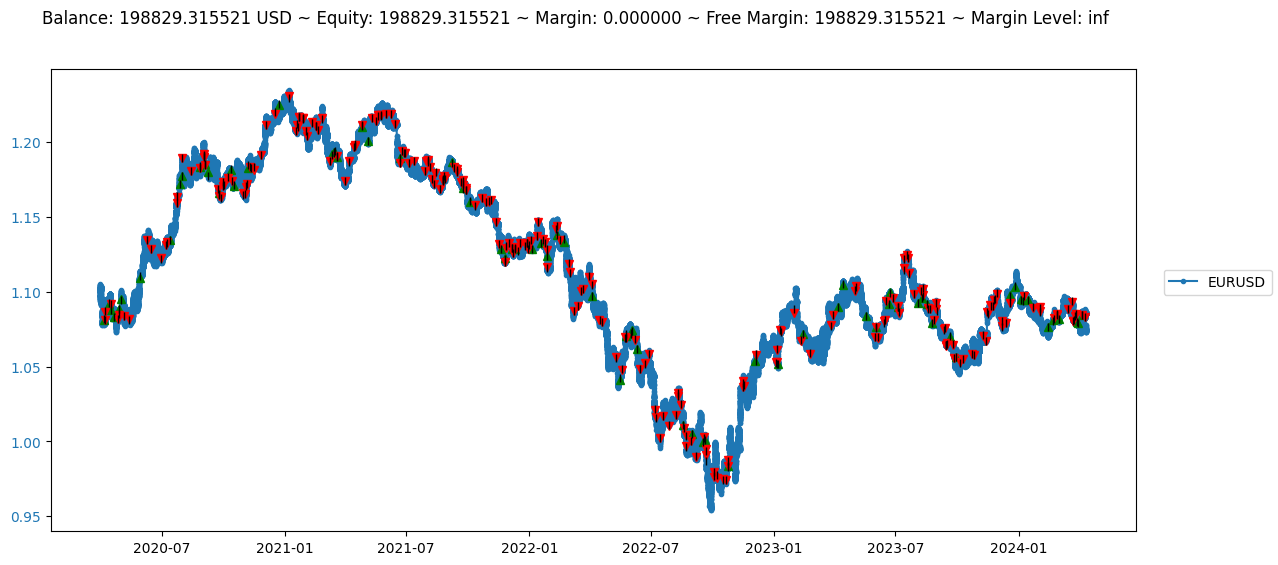

In [14]:
env_testing.render('simple_figure')

In [29]:
max_episode = 120
for model_nbr in range(0, int(max_episode)+10, 10):
    print(f'Model: {model_nbr}')
    over_episodes_rewards = []
    over_episodes_balance = []
    obs_training, info_training = env_train.reset(seed=2024)
    for episode in range(0, 10):
        obs_test, info_test = env_testing.reset(seed=2024)
        
        # model_ppo.learn(total_timesteps=25000, callback=ProgressBarCallback(100))

        total_reward = 0
        done_test = False
        env_train.time_points = list(symbols[1]['EURUSD'].iloc[-int(training_length):-(int(testing_length)-int(model_nbr)), :].index)
        obs_training, info_training = env_train.reset(seed=2024)
        model_ppo = PPO.load(f'models\model_{model_nbr}.pkl', env=env_train)

        while not done_test:
            action, _states = model_ppo.predict(obs_test)
            obs_test, reward_test, terminated_test, truncated_test, info_test = env_testing.step(action)
            done_test = terminated_test or truncated_test

            total_reward += reward_test
            if done_test:
                break
        over_episodes_balance.append(info_test['balance'])
        over_episodes_rewards.append(total_reward)
        print(f'Episode: {episode}, Reward: {total_reward:.3f}, Balance: {info_test["balance"]:.3f}')
    print_stats(over_episodes_rewards)
    print_stats(over_episodes_balance)

Model: 0
Episode: 0, Reward: -3484.361, Balance: 196538.559
Episode: 1, Reward: -3464.076, Balance: 196535.924
Episode: 2, Reward: -3578.827, Balance: 196424.747
Episode: 3, Reward: -4249.509, Balance: 195750.491
Episode: 4, Reward: -5198.528, Balance: 194831.823
Episode: 5, Reward: -6431.152, Balance: 193626.301
Episode: 6, Reward: -5711.899, Balance: 194307.236
Episode: 7, Reward: -1524.592, Balance: 198471.658
Episode: 8, Reward: -1999.785, Balance: 198023.110
Episode: 9, Reward: -1087.783, Balance: 198912.217
Min. Reward          :  -6431.152
Avg. Reward          :  -3673.051
Max. Reward          :  -1087.783
Min. Reward          : 193626.301
Avg. Reward          : 196342.207
Max. Reward          : 198912.217
Model: 10
Episode: 0, Reward: -413.961, Balance: 199586.285
Episode: 1, Reward: -2742.594, Balance: 197257.406
Episode: 2, Reward: -2100.404, Balance: 197899.596
Episode: 3, Reward: -1619.138, Balance: 198380.862
Episode: 4, Reward: -4788.417, Balance: 195211.583
Episode: 5, R

KeyboardInterrupt: 

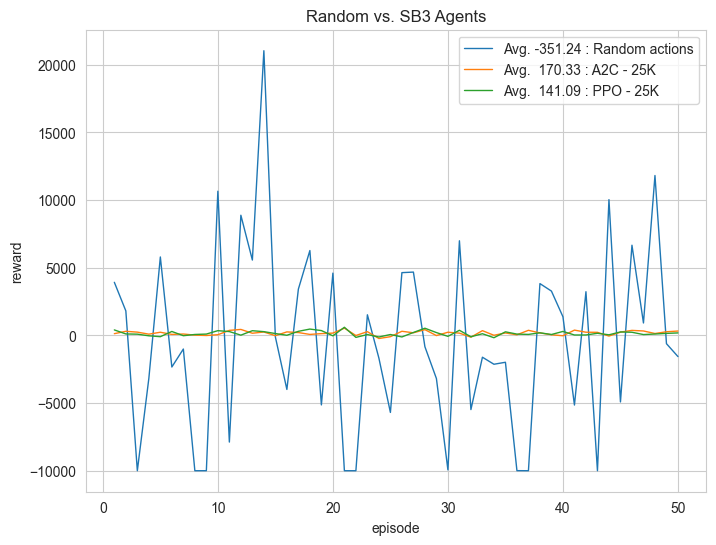

In [ ]:
# data = pd.DataFrame(plot_data)

# sns.set_style('whitegrid')
# plt.figure(figsize=(8, 6))

# for key in plot_data:
#     if key == 'x':
#         continue
#     label = plot_settings[key]['label']
#     line = plt.plot('x', key, data=data, linewidth=1, label=label)

# plt.xlabel('episode')
# plt.ylabel('reward')
# plt.title('Random vs. SB3 Agents')
# plt.legend()
# plt.show()